## Importar librerías

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster
from onnxmltools.convert import convert_lightgbm
from onnxmltools.convert.lightgbm.operator_converters.LightGbm import convert_lightgbm
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Cargar
tester_files_folder = "C:/Users/Administrador/AppData/Roaming/MetaQuotes/Tester/6C3C6A11D1C3791DD4DBF45421BF8028/Agent-127.0.0.1-3000/MQL5/Files"
df_buy = pd.read_csv(os.path.join(tester_files_folder, "buy_dataset.csv"))
df_sell = pd.read_csv(os.path.join(tester_files_folder, "sell_dataset.csv"))
print(f"Buy -> Trades: {df_buy.shape[0]} Features: {df_buy.shape[1]-1}")
print(f"Sell -> Trades: {df_sell.shape[0]} Features: {df_sell.shape[1]-1}")

Buy -> Trades: 9946 Features: 55
Sell -> Trades: 5800 Features: 55


In [15]:
df_buy

,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,...,data_46,data_47,data_48,data_49,data_50,data_51,data_52,data_53,data_54,target
0,0.000096,7.725181,-3.157604,31.211489,9.42,549548.0,19.981752,10.530902,-6.478576,-0.433547,...,-2.576348,47.373791,6.60,550138.0,6.013319,14.960112,0.050351,1.463717,2.973608,1.0
1,-0.001592,4.387366,4.786392,42.762417,5.80,811289.0,8.000000,8.532730,-2.180799,-2.236068,...,4.048388,90.535177,6.40,811308.0,12.132601,7.322025,4.441409,0.961578,-0.873346,1.0
2,-0.008663,9.737735,11.903652,49.517644,12.60,671304.0,27.942799,1.790484,-0.796532,0.000000,...,5.352127,96.927473,15.20,672118.0,65.600000,-7.029776,30.399092,0.347280,-2.543101,0.0
3,-0.000482,9.929412,11.498414,36.492880,6.50,672043.0,24.864432,56.777321,-3.837210,-0.205853,...,10.185841,99.182762,7.14,672071.0,23.130932,57.060098,15.303686,0.701575,0.352670,0.0
4,-0.021461,9.989447,12.256009,61.203440,17.96,597015.0,51.358255,101.414443,-9.946662,-1.052287,...,6.914836,66.979964,23.36,598027.0,97.717962,95.858837,29.966156,0.442075,-2.805927,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9941,-0.002642,9.373034,5.916225,23.816256,6.86,483716.0,14.086362,41.967356,-3.448948,0.639790,...,5.856430,84.359144,10.34,483691.0,25.305051,44.167504,7.064092,-1.706203,2.962458,1.0
9942,-0.001129,9.252218,27.876857,21.761133,22.48,572243.0,46.896652,58.954861,-1.121409,1.667822,...,21.649438,95.930457,35.98,573381.0,121.143617,56.485229,37.337185,-1.084524,-0.523241,1.0
9943,-0.000292,9.291735,2.969917,36.035379,3.64,519419.0,7.858753,16.592957,-0.932728,0.417510,...,1.978891,88.083867,6.22,519660.0,17.348014,16.220069,6.160333,-0.421192,-1.136746,0.0
9944,-0.008529,5.027029,27.921929,20.524620,15.04,552418.0,34.784456,77.080301,-1.636240,-0.343228,...,20.812891,91.281850,34.02,554109.0,42.034196,70.315106,32.838086,-1.411873,1.875525,0.0


In [16]:
df_sell

,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,...,data_46,data_47,data_48,data_49,data_50,data_51,data_52,data_53,data_54,target
0,0.005641,90.439442,-17.276256,41.815769,10.70,578779.0,21.850400,-114.181346,2.588888,1.037730,...,-15.572567,12.001024,14.30,578845.0,53.426585,-111.910069,-15.601348,1.139605,0.044099,1.0
1,0.000555,90.827943,-5.455218,90.021376,4.80,814688.0,11.027239,-56.849885,5.066888,-0.085380,...,-7.873072,68.957952,8.00,814719.0,11.142711,-62.298892,2.260958,-0.436934,-2.681475,0.0
2,0.000401,90.270916,-3.587423,65.105382,6.20,475689.0,19.241622,-7.073926,2.989235,-0.412048,...,-1.933298,7.047340,6.50,475229.0,21.203773,-7.062707,-10.850500,-0.468360,-1.517686,1.0
3,0.000000,93.015069,-2.243515,87.581625,7.84,495384.0,13.529228,-9.081937,1.052601,-1.134285,...,0.098661,5.935622,10.58,494453.0,3.200000,-9.242378,-8.180173,-0.052408,-2.324219,1.0
4,0.001590,91.731787,-0.250985,30.197882,4.80,813398.0,8.979978,-24.407981,0.084937,2.017344,...,3.729211,9.394189,10.60,813217.0,33.523723,-20.669759,-10.808259,1.431140,2.174672,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5795,0.021022,90.225053,-0.513236,53.027547,28.64,590401.0,62.771000,-1.472117,14.546233,0.760869,...,9.345615,22.364662,36.40,588945.0,88.760928,2.710216,-34.955486,0.179450,-1.534158,1.0
5796,0.060307,90.001287,-5.509297,40.554039,30.48,503412.0,84.242469,-24.312590,23.998990,0.822561,...,-0.280489,31.073360,29.66,503646.0,93.017194,-22.038163,-24.469652,-0.479389,-3.181783,0.0
5797,0.000062,93.506242,-0.258856,96.269336,2.00,814737.0,3.200000,-28.549455,1.782383,-0.821056,...,-1.133420,79.490433,3.44,814686.0,7.958291,-31.288317,0.898396,-0.498474,-2.475040,1.0
5798,0.030313,90.223095,17.218428,40.113710,19.42,484994.0,27.841149,-13.348812,13.855918,1.369611,...,18.546656,76.830883,17.10,485083.0,33.442488,-17.305949,6.202925,-1.768093,3.481454,0.0


In [8]:
# Dividir 
X_buy = df_buy.drop(columns='target').values
y_buy = df_buy['target'].values
X_buy_train, X_buy_test, y_buy_train, y_buy_test = train_test_split(X_buy, y_buy, test_size=0.2, random_state=42)
X_sell = df_sell.drop(columns='target').values
y_sell = df_sell['target'].values
X_sell_train, X_sell_test, y_sell_train, y_sell_test = train_test_split(X_sell, y_sell, test_size=0.2, random_state=42)

In [9]:
param_grid = {
    'feature_selection__threshold': ['mean', 'median'],
    'xgb__n_estimators': [500],
    'xgb__max_depth': [3],
    'xgb__learning_rate': [0.01],
    'xgb__subsample': [0.6],
    'xgb__colsample_bytree': [0.9],
    'xgb__gamma': [0],
    #'scaler__with_mean': [True, False],  # Hiperparámetro del escalador
    #'scaler__with_std': [True, False]    # Hiperparámetro del escalador
}


In [10]:
# Crear pipe y entrenar
pipe_buy = Pipeline([
    ("scaler", StandardScaler()),
    ('feature_selection', SelectFromModel(xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='mlogloss'
    ))),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
    ])
grid_search_buy = GridSearchCV(
    estimator=pipe_buy,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_search_buy.fit(X_buy_train, y_buy_train)
model_buy = grid_search_buy.best_estimator_
pipe_sell = Pipeline([
    ("scaler", StandardScaler()),
    ('feature_selection', SelectFromModel(xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='mlogloss'
    ))),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
    ])
grid_search_sell = GridSearchCV(
    estimator=pipe_sell,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_search_sell.fit(X_sell_train, y_sell_train)
model_sell = grid_search_sell.best_estimator_

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


In [13]:
grid_search_buy.best_params_

{'feature_selection__threshold': 'median',
 'scaler__with_mean': False,
 'scaler__with_std': True,
 'xgb__colsample_bytree': 0.9,
 'xgb__gamma': 0,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 500,
 'xgb__subsample': 0.6}

In [14]:
grid_search_sell.best_params_

{'feature_selection__threshold': 'mean',
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'xgb__colsample_bytree': 0.9,
 'xgb__gamma': 0,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 500,
 'xgb__subsample': 0.6}

In [11]:
update_registered_converter(
    xgb.XGBClassifier,
    "XGBClassifier",
    calculate_linear_classifier_output_shapes,
    convert_xgboost,
    options={'nocl': [False], 'zipmap': [True, False, 'columns']}
)

In [12]:
model_buy_onnx = convert_sklearn(
    model_buy,
    'pipeline_buy_xgboost',
    [('input', FloatTensorType([None, X_buy_train.shape[1]]))],
    target_opset={'': 12, 'ai.onnx.ml': 2}
)
model_sell_onnx = convert_sklearn(
    model_sell,
    'pipeline_sell_xgboost',
    [('input', FloatTensorType([None, X_buy_train.shape[1]]))],
    target_opset={'': 12, 'ai.onnx.ml': 2}
)
mql5_files_folder = "C:/Users/Administrador/AppData/Roaming/MetaQuotes/Terminal/6C3C6A11D1C3791DD4DBF45421BF8028/MQL5/Files"
with open(os.path.join(mql5_files_folder, "xgboost_buy.onnx"), 'wb') as f:
    f.write(model_buy_onnx.SerializeToString())
with open(os.path.join(mql5_files_folder, "xgboost_sell.onnx"), 'wb') as f:
    f.write(model_sell_onnx.SerializeToString())

Classification Report
               precision    recall  f1-score   support

         0.0       0.65      0.41      0.51      1007
         1.0       0.56      0.78      0.65       983

    accuracy                           0.59      1990
   macro avg       0.61      0.59      0.58      1990
weighted avg       0.61      0.59      0.58      1990



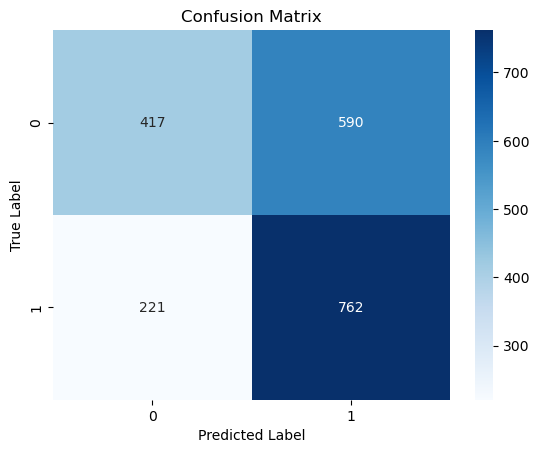

In [18]:
y_pred = model_buy.predict(X_buy_test) 

# For binary classification, you might want to threshold the predictions since these are probabilities
y_pred_binary = np.round(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_buy_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion-matrix xgboost")  # Display the heatmap


print("Classification Report\n",
      classification_report(y_buy_test, y_pred_binary))

Classification Report
               precision    recall  f1-score   support

         0.0       0.58      0.63      0.60       574
         1.0       0.60      0.54      0.57       586

    accuracy                           0.59      1160
   macro avg       0.59      0.59      0.59      1160
weighted avg       0.59      0.59      0.59      1160



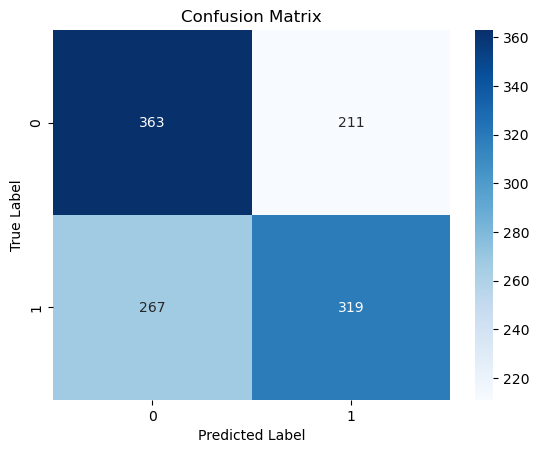

In [19]:
y_pred = model_sell.predict(X_sell_test) 

# For binary classification, you might want to threshold the predictions since these are probabilities
y_pred_binary = np.round(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_sell_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion-matrix xgboost")  # Display the heatmap


print("Classification Report\n",
      classification_report(y_sell_test, y_pred_binary))